In [1]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [19]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 1234
#### Using data from yahoo finance
data = YahooDataProvider(
        tickers= ["JPM", "GS", "V", "UNH", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],
        start=datetime.datetime(2016, 1, 1),
        end=datetime.datetime(2017, 12, 31),
    )
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


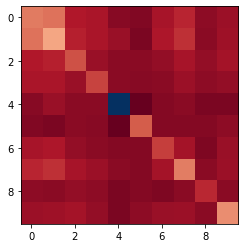

In [20]:
# plot sigma
plt.imshow(sigma, interpolation="nearest", cmap = "RdBu")
plt.show()


In [21]:
print(mu)
print('\n')
print(sigma)

[0.00114768 0.0008539  0.00085819 0.00136896 0.00126204 0.00112448
 0.00015762 0.00162736 0.00089941 0.00014823]


[[ 1.72799038e-04  1.63800514e-04  6.14082353e-05  5.46153335e-05
   1.84147400e-05  1.41265759e-05  5.25374135e-05  7.74431915e-05
   2.70271700e-05  4.22589694e-05]
 [ 1.63800514e-04  2.19866758e-04  7.01808868e-05  5.67654608e-05
   3.76495512e-05  8.03511386e-06  5.82946836e-05  9.01187686e-05
   2.36406276e-05  4.45232386e-05]
 [ 6.14082353e-05  7.01808868e-05  1.25341488e-04  3.67578735e-05
   2.30019726e-05  2.17668552e-05  3.11130500e-05  5.18761035e-05
   3.12879613e-05  4.90846597e-05]
 [ 5.46153335e-05  5.67654608e-05  3.67578735e-05  1.11782171e-04
   2.31197406e-05  1.85089380e-05  2.39103615e-05  4.16139205e-05
   2.42051843e-05  3.11093242e-05]
 [ 1.84147400e-05  3.76495512e-05  2.30019726e-05  2.31197406e-05
   7.67564608e-04 -1.57893790e-05  1.66760381e-05  2.34142881e-05
   5.98045378e-06  8.00679388e-06]
 [ 1.41265759e-05  8.03511386e-06  2.17668552e-05 

In [22]:
q = 0.5  # set risk factor
budget = num_assets // 10  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 8.639951897849313e-05*x_0^2 + 0.000163800514005987..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [23]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [24]:
#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], value -0.0015

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 1 0 0]	-0.0015		1.0000
[0 0 0 0 0 0 0 0 1 0]	-0.0009		0.0000
[0 1 1 1 1 0 1 0 1 0]	25.2990		0.0000
[1 0 1 1 1 0 1 0 1 0]	25.2987		0.0000
[0 0 1 1 1 0 1 0 1 0]	16.1904		0.0000
[1 1 0 1 1 0 1 0 1 0]	25.2989		0.0000
[0 1 0 1 1 0 1 0 1 0]	16.1905		0.0000
[1 0 0 1 1 0 1 0 1 0]	16.1901		0.0000
[0 0 0 1 1 0 1 0 1 0]	9.1061		0.0000
[1 1 1 0 1 0 1 0 1 0]	25.2994		0.0000
[0 1 1 0 1 0 1 0 1 0]	16.1910		0.0000
[1 0 1 0 1 0 1 0 1 0]	16.1907		0.0000
[0 0 1 0 1 0 1 0 1 0]	9.1067		0.0000
[1 1 0 0 1 0 1 0 1 0]	16.1909		0.0000
[0 1 0 0 1 0 1 0 1 0]	9.1067		0.0000
[1 0 0 0 1 0 1 0 1 0]	9.1064		0.0000
[0 0 0 0 1 0 1 0 1 0]	4.0467		0.0000
[1 1 1 1 0 0 1 0 1 0]	25.2991		0.0000
[0 1 1 1 0 0 1 0 1 0]	16.1906		0.0000
[1 0 1 1 0 0 1 0 1 0]	16.1903		0.0000
[0 0 1 1 0 0 1 0 1 0]	9.1063		0.0000
[1 1 0 1

In [25]:
#### VQE solution
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], value -0.0015

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 0 0 0]	-0.0007		0.5095
[0 0 0 0 0 0 1 0 0 0]	-0.0001		0.4877
[0 1 0 0 1 0 0 0 0 0]	1.0105		0.0004
[0 0 0 0 1 0 1 0 0 0]	1.0112		0.0003
[0 1 0 0 0 0 1 0 0 0]	1.0113		0.0003
[0 0 0 0 0 0 0 0 0 0]	1.0121		0.0003
[1 0 0 0 0 0 0 0 1 0]	1.0102		0.0002
[0 0 0 0 1 0 0 0 0 0]	-0.0009		0.0002
[0 1 0 0 1 0 1 0 0 0]	4.0469		0.0001
[0 1 1 0 0 0 0 0 0 0]	1.0107		0.0001
[0 1 0 0 0 1 0 0 0 0]	1.0103		0.0001
[1 1 0 0 0 0 0 0 0 0]	1.0105		0.0001
[0 1 0 0 0 0 0 1 0 0]	1.0099		0.0001
[0 0 0 0 0 1 1 0 0 0]	1.0110		0.0001
[0 0 1 0 0 0 1 0 0 0]	1.0113		0.0001
[0 0 0 0 0 0 1 1 0 0]	1.0105		0.0001
[0 0 0 0 0 0 1 0 1 0]	1.0112		0.0000
[1 0 0 1 0 0 0 0 0 0]	1.0098		0.0000
[0 0 0 0 0 0 0 0 0 1]	-0.0001		0.0000
[0 1 0 0 0 0 0 0 0 1]	1.0114		0.0000
[0 1 0 0 0 0 1 0 0 1]	4.0478		0.0000
[0 1 0 0 0 0 0 0 1 

In [26]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)



Optimal: selection [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], value -0.0015

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0]	1.0121		0.4022
[0 0 0 0 0 0 0 1 0 0]	-0.0015		0.0463
[0 0 0 1 0 0 0 0 0 0]	-0.0013		0.0463
[1 0 0 0 0 0 0 0 0 0]	-0.0011		0.0463
[0 0 0 0 0 1 0 0 0 0]	-0.0011		0.0463
[0 0 0 0 1 0 0 0 0 0]	-0.0009		0.0463
[0 0 0 0 0 0 0 0 1 0]	-0.0009		0.0463
[0 1 0 0 0 0 0 0 0 0]	-0.0007		0.0463
[0 0 1 0 0 0 0 0 0 0]	-0.0008		0.0463
[0 0 0 0 0 0 1 0 0 0]	-0.0001		0.0462
[0 0 0 0 0 0 0 0 0 1]	-0.0001		0.0462
[0 0 0 1 0 0 0 1 0 0]	1.0093		0.0029
[1 0 0 0 0 0 0 1 0 0]	1.0096		0.0029
[0 0 0 0 0 1 0 1 0 0]	1.0096		0.0029
[0 1 0 0 0 0 0 1 0 0]	1.0099		0.0029
[1 0 0 1 0 0 0 0 0 0]	1.0098		0.0029
[0 0 1 0 0 0 0 1 0 0]	1.0098		0.0029
[0 0 0 0 1 0 0 1 0 0]	1.0097		0.0029
[0 0 0 0 0 0 0 1 1 0]	1.0098		0.0029
[1 1 0 0 0 0 0 0 0 0]	1.0105		0.0029
[0 0 0 1 0 1 0 0 0 0]	1.0098		0.0029
[0 0 0 1 1 0 

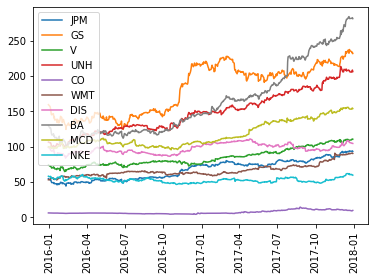

In [27]:
stocks = ["JPM", "GS", "V", "UNH", "CO"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2017, 12, 31),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()